## Приближенные методы к вычислению Q-функции

Начнем с определения агента, который обучается, используя Q-функцию

In [1]:
import random, math

import numpy as np
from collections import defaultdict

class QLearningAgent():
    """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
    """
    def __init__(self,alpha,epsilon,discount,getLegalActions):
        "We initialize agent and Q-values here."
        self.getLegalActions= getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def getQValue(self, state, action):
        """
          Returns Q(state,action)
        """
        return self._qValues[state][action]

    def setQValue(self,state,action,value):
        """
          Sets the Qvalue for [state,action] to the given value
        """
        self._qValues[state][action] = value

Добавим нашему агенту возможность вычислять оценки $V$: $V_{(i+1)}(s) = \max_a Q_i(s,a)$

In [2]:
def getValue(self, state):
    """
      Returns max_action Q(state,action)
      where the max is over legal actions.
    """
    
    possibleActions = self.getLegalActions(state)
    #If there are no legal actions, return 0.0
    if len(possibleActions) == 0:
        return 0.0

    value = max([self._qValues[state][action] for action in possibleActions])
    return value

QLearningAgent.getValue =  getValue

Стратегия нашего агента будет заключаться в выборе лучшего действия, в соответствии с оценками $Q$: $a = argmax_a Q(s,a)$

In [11]:
def getPolicy(self, state):
    """
      Compute the best action to take in a state. 
      
    """
    possibleActions = self.getLegalActions(state)

    #If there are no legal actions, return None
    if len(possibleActions) == 0:
        return None
    
    best_action = None
    best_q = 0
    for action in possibleActions:
        q = self._qValues[state][action]
        if best_action is None or best_q < q:
            best_action = action
            best_q = q
    
    return best_action

QLearningAgent.getPolicy = getPolicy

Для конкретной ситуации мы будем выбирать действие, используя $\epsilon$-жадный подход:

In [4]:
def getAction(self, state):
    """
      Compute the action to take in the current state, including exploration.  
      
      With probability self.epsilon, we should take a random action.
      otherwise - the best policy action (self.getPolicy).

    """
    
    # Pick Action
    possibleActions = self.getLegalActions(state)

    action = None
    #If there are no legal actions, return None
    if len(possibleActions) == 0:
        return action

    if self.epsilon > random.random():
        action = random.choice(possibleActions)
    else:
        action = self.getPolicy(state)
    
    return action

QLearningAgent.getAction = getAction

Функция обнолвления оценки $Q$: $Q_i(s, a) = r(s,a,s') + \gamma V_{i}(s')$

In [5]:
def update(self, state, action, nextState, reward):
    """
      You should do your Q-Value update here

      NOTE: You should never call this function,
      it will be called on your behalf


    """
   
    #reference_qvalue = <the "correct state value", uses reward and the value of next state>
    reference_qvalue = reward + self.discount * self.getValue(nextState)
    
    updated_qvalue = (1 - self.alpha) * self.getQValue(state, action) + self.alpha * reference_qvalue
    self.setQValue(state, action, updated_qvalue)
    
QLearningAgent.update = update

Тестируем нашего агента на задаче Taxi

In [6]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

In [12]:
agent = QLearningAgent(alpha=0.5, epsilon=0.1, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [13]:
assert 'getPolicy' in dir(agent)

In [14]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        #a = <get agent to pick action given state s>
        a = agent.getAction(s)
        
        next_s, r, done, _ = env.step(a)
        
        #<train(update) agent for state s>
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

0.04059802359226594


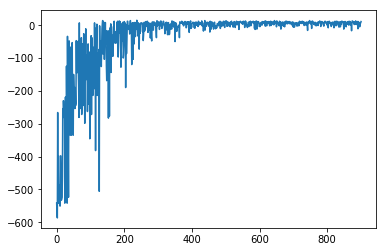

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

agent = QLearningAgent(alpha=0.5, epsilon=0.1, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    
    agent.epsilon *= 0.999
    
    if i % 100 ==0:
        clear_output(True)
        print(agent.epsilon)
        plt.plot(rewards)
        plt.show()

## Будем приближенно считать значение оценок $Q$

![img](qlearning.png)

Будем использовать классическую задачу с непрерывным набором состояний

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


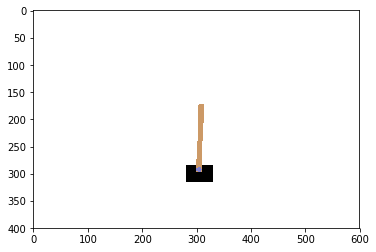

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [2]:
env.close()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras.layers as L

tf.reset_default_graph()
sess = tf.InteractiveSession()
set_session(sess)

Using TensorFlow backend.


Попробуем небольшую сетку - два скрытых слоя со 100 нейронами:

In [4]:
from keras.models import Sequential

network = Sequential()
network.add(L.InputLayer(state_dim))

network.add(L.Dense(200, activation='relu'))
#network.add(L.Dense(100, activation='relu'))
#network.add(L.Dense(50, activation='softmax'))
network.add(L.Dense(n_actions))

In [5]:
import numpy as np


def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    action = None
    if epsilon > random.random():
        action = random.choice(range(n_actions))
    else:
        action = np.argmax(q_values)

    return action

In [6]:
import keras
import random

assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


Будем обучать нашу сеть, используя так называемую функцию потерь TD (time-difference):

$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Хитрость здесь заключается в том, что мы используем "отложенное" состояние сети $Q_{-}(s',a')$, которое не изменяется в процессе распространения ошибки по текущему состоянию сети.

In [7]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [8]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [9]:
gamma = 0.99

# compute q-values for all actions in next states
#predicted_next_qvalues = ###YOUR CODE - apply network to get q-values for next_states_ph
predicted_next_qvalues = network(next_states_ph)

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

# compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [10]:
#mean squared error loss to minimize
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [11]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

Теперь проверим как работает наш нейроагент

In [12]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [13]:
epsilon = 0.5
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break

epoch #0	mean reward = 24.450	epsilon = 0.500
epoch #1	mean reward = 13.920	epsilon = 0.495
epoch #2	mean reward = 13.050	epsilon = 0.490
epoch #3	mean reward = 13.360	epsilon = 0.485
epoch #4	mean reward = 14.600	epsilon = 0.480
epoch #5	mean reward = 25.430	epsilon = 0.475
epoch #6	mean reward = 16.640	epsilon = 0.471
epoch #7	mean reward = 17.500	epsilon = 0.466
epoch #8	mean reward = 12.890	epsilon = 0.461
epoch #9	mean reward = 14.240	epsilon = 0.457
epoch #10	mean reward = 17.080	epsilon = 0.452
epoch #11	mean reward = 11.970	epsilon = 0.448
epoch #12	mean reward = 14.380	epsilon = 0.443
epoch #13	mean reward = 16.840	epsilon = 0.439
epoch #14	mean reward = 13.870	epsilon = 0.434
epoch #15	mean reward = 13.140	epsilon = 0.430
epoch #16	mean reward = 17.350	epsilon = 0.426
epoch #17	mean reward = 13.010	epsilon = 0.421
epoch #18	mean reward = 18.300	epsilon = 0.417
epoch #19	mean reward = 39.830	epsilon = 0.413
epoch #20	mean reward = 28.070	epsilon = 0.409
epoch #21	mean reward =

KeyboardInterrupt: 